In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import cartopy
import pandas as pn
from datetime import datetime
import gsw
from holteandtalley import HolteAndTalley
import os
from xmovie import Movie
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs

## Opening the Phosphate Data from the World Ocean Database

In [2]:
# First set up the dataframe with the initial netcdf
array = xr.open_dataset("/Users/nyelab/Downloads/ocldb1625068230.20558.OSD/wod_013574410O.nc")
data = pn.DataFrame(data = array.Phosphate, columns = ['phosphate'])
k=1
data['depth'] = array.z.values 
year = pn.to_datetime(array.time.values).year
month = pn.to_datetime(array.time.values).month
day = pn.to_datetime(array.time.values).day
data['year']=year
data['month']=month
data['day']=day
data['lat']=array.lat.values
data['lon']=array.lon.values
data['station']=k

In [3]:
# Next cycle through all netcdfs and append new data to the dataframe
k=2
for i in os.listdir("/Users/nyelab/Downloads/ocldb1625068230.20558.OSD/"):
    if i.startswith("wo"):
        string = '/Users/nyelab/Downloads/ocldb1625068230.20558.OSD/'+i
        array = xr.open_dataset(string)
        data2 = pn.DataFrame(data = array.Phosphate, columns = ['phosphate'])
        data2['depth'] = array.z.values 
        year = pn.to_datetime(array.time.values).year
        month = pn.to_datetime(array.time.values).month
        day = pn.to_datetime(array.time.values).day
        data2['year']=year
        data2['month']=month
        data2['day']=day
        data2['lat']=array.lat.values
        data2['lon']=array.lon.values
        data2['station']=k
        k=k+1
        data = data.append(data2)
        array.close()

In [4]:
# index needed to be reset
data = data.reset_index()
data

,index,phosphate,depth,year,month,day,lat,lon,station
0,0,6.200000e-02,4.056877,2007,7,26,39.349201,-74.085197,1
1,1,-1.000000e+10,4.190848,2007,7,26,39.349201,-74.085197,1
2,2,-1.000000e+10,4.332758,2007,7,26,39.349201,-74.085197,1
3,3,7.800002e-02,10.047769,2007,7,26,39.349201,-74.085197,1
4,4,-1.000000e+10,10.091433,2007,7,26,39.349201,-74.085197,1
...,...,...,...,...,...,...,...,...,...
1615,14,1.131707e+00,1774.000000,1982,6,13,38.208332,-72.951668,209
1616,15,1.112195e+00,1970.000000,1982,6,13,38.208332,-72.951668,209
1617,16,1.131707e+00,2166.000000,1982,6,13,38.208332,-72.951668,209
1618,17,1.121951e+00,2357.000000,1982,6,13,38.208332,-72.951668,209


In [5]:
# Load NYB shapefile
NYB = gpd.read_file('/Users/nyelab/Desktop/NYB Indicators/Datasets/Shapefiles/PlanningArea_NYocean_NYSDOS.shp')

In [6]:
# Alter the projection to WGS84 see https://epsg.io/4326
NYB = NYB.to_crs(epsg=4326)

In [7]:
# Extract the polygon
nyb_shape = NYB.geometry[0]

In [8]:
def inNYB(dataframe, shape, lon_col_name, lat_col_name):
    yn = str(input("Does your dataframe have a NYB column? y/n"))
    if yn == 'y':
        print ('Great, starting inNYB')
    else:
        print ('OK, a NYB column has been added')
        dataframe['NYB'] = np.nan
    for i in range(len(dataframe)):
        if Point(dataframe[lon_col_name][i], dataframe[lat_col_name][i]).within(shape) == True:
            dataframe['NYB'][i] = 'NYB'
    return dataframe

In [9]:
#check which points are within the NYB
data = inNYB(data, nyb_shape, 'lon', 'lat')

Does your dataframe have a NYB column? y/n n


OK, a NYB column has been added


<ipython-input-8-ff8895e12bd9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['NYB'][i] = 'NYB'
/Users/nyelab/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [10]:
# subset for NYB data only
NYB_data = data[data.NYB == 'NYB']

In [16]:
# get one each lat lon and year for each station
LON = NYB_data[NYB_data.station == 4].lon
LAT = NYB_data[NYB_data.station == 4].lat
YEAR = NYB_data[NYB_data.station == 4].year

for i in NYB_data.station.unique()[1:]:
    LON = LON.append(NYB_data[NYB_data.station == i].lon)
    LAT = LAT.append(NYB_data[NYB_data.station == i].lat)
    YEAR = YEAR.append(NYB_data[NYB_data.station == i].year)

Text(0.5, 1.0, 'Phosphate')

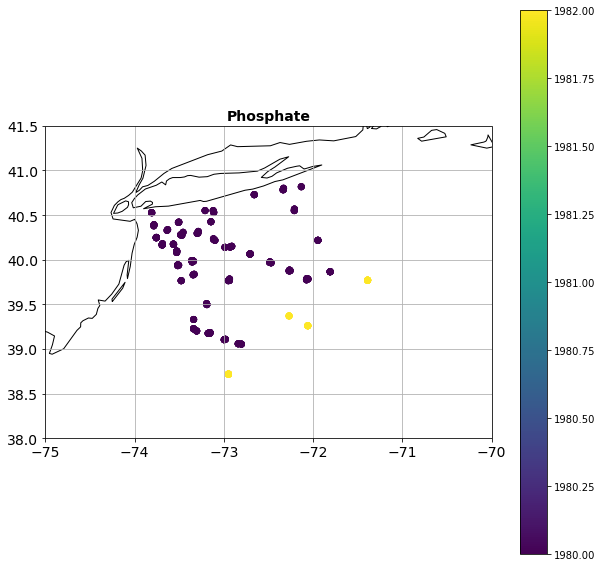

In [56]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C = ax.scatter(LON,LAT,c=YEAR)
fig.colorbar(C)
ax.set_xticks(np.arange(-75,-69,1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(38,42,0.5), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=14)
plt.title('Phosphate', fontsize = 14, fontweight = 'bold')

In [37]:
NYB_data.year.unique()

array([1980, 1982])

## Nitrate

In [41]:
# First set up the dataframe with the initial netcdf
array = xr.open_dataset("/Users/nyelab/Downloads/ocldb1625068365.21208.OSD/wod_013574410O.nc")
datan = pn.DataFrame(data = array.Nitrate, columns = ['nitrate'])
k=1
datan['depth'] = array.z.values 
year = pn.to_datetime(array.time.values).year
month = pn.to_datetime(array.time.values).month
day = pn.to_datetime(array.time.values).day
datan['year']=year
datan['month']=month
datan['day']=day
datan['lat']=array.lat.values
datan['lon']=array.lon.values
datan['station']=k

In [42]:
# Next cycle through all netcdfs and append new data to the dataframe
k=2
for i in os.listdir("/Users/nyelab/Downloads/ocldb1625068365.21208.OSD/"):
    if i.startswith("wo"):
        string = '/Users/nyelab/Downloads/ocldb1625068365.21208.OSD/'+i
        array = xr.open_dataset(string)
        data2n = pn.DataFrame(data = array.Nitrate, columns = ['nitrate'])
        data2n['depth'] = array.z.values 
        year = pn.to_datetime(array.time.values).year
        month = pn.to_datetime(array.time.values).month
        day = pn.to_datetime(array.time.values).day
        data2n['year']=year
        data2n['month']=month
        data2n['day']=day
        data2n['lat']=array.lat.values
        data2n['lon']=array.lon.values
        data2n['station']=k
        k=k+1
        datan = datan.append(data2n)
        array.close()

In [43]:
# index needed to be reset
datan = datan.reset_index()
datan

,index,nitrate,depth,year,month,day,lat,lon,station
0,0,4.200000e-02,4.056877,2007,7,26,39.349201,-74.085197,1
1,1,-1.000000e+10,4.190848,2007,7,26,39.349201,-74.085197,1
2,2,-1.000000e+10,4.332758,2007,7,26,39.349201,-74.085197,1
3,3,5.700001e-02,10.047769,2007,7,26,39.349201,-74.085197,1
4,4,-1.000000e+10,10.091433,2007,7,26,39.349201,-74.085197,1
...,...,...,...,...,...,...,...,...,...
347,14,1.736585e+01,1774.000000,1982,6,13,38.208332,-72.951668,25
348,15,1.736585e+01,1970.000000,1982,6,13,38.208332,-72.951668,25
349,16,1.756098e+01,2166.000000,1982,6,13,38.208332,-72.951668,25
350,17,1.736585e+01,2357.000000,1982,6,13,38.208332,-72.951668,25


In [44]:
#check which points are within the NYB
datan = inNYB(datan, nyb_shape, 'lon', 'lat')

Does your dataframe have a NYB column? y/n n


OK, a NYB column has been added


<ipython-input-8-ff8895e12bd9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['NYB'][i] = 'NYB'
/Users/nyelab/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [45]:
# subset for NYB data only
NYB_datan = datan[datan.NYB == 'NYB']

In [46]:
# get one each lat lon and year for each station
LON = NYB_datan[NYB_datan.station == 4].lon
LAT = NYB_datan[NYB_datan.station == 4].lat
YEAR = NYB_datan[NYB_datan.station == 4].year

for i in NYB_datan.station.unique()[1:]:
    LON = LON.append(NYB_datan[NYB_datan.station == i].lon)
    LAT = LAT.append(NYB_datan[NYB_datan.station == i].lat)
    YEAR = YEAR.append(NYB_datan[NYB_datan.station == i].year)

Text(0.5, 1.0, 'Nitrate')

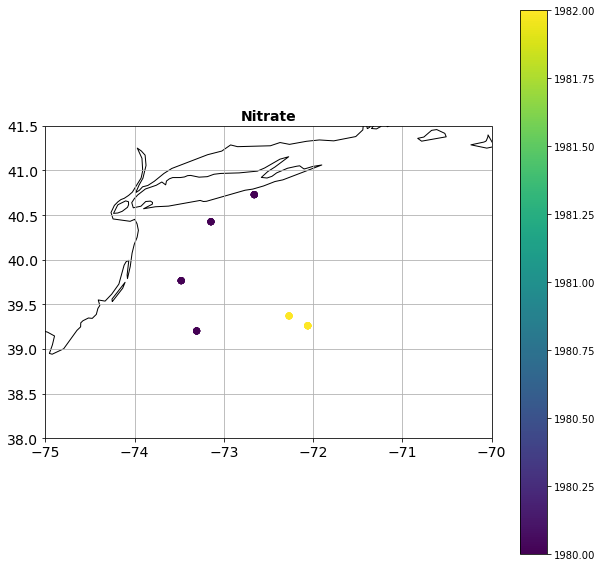

In [47]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C = ax.scatter(LON,LAT,c=YEAR)
fig.colorbar(C)
ax.set_xticks(np.arange(-75,-69,1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(38,42,0.5), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=14)
plt.title('Nitrate', fontsize = 14, fontweight = 'bold')

## Silicate

In [48]:
# First set up the dataframe with the initial netcdf
array = xr.open_dataset("/Users/nyelab/Downloads/ocldb1625613553.31148.OSD/wod_008081453O.nc")
datas = pn.DataFrame(data = array.Silicate, columns = ['silicate'])
k=1
datas['depth'] = array.z.values 
year = pn.to_datetime(array.time.values).year
month = pn.to_datetime(array.time.values).month
day = pn.to_datetime(array.time.values).day
datas['year']=year
datas['month']=month
datas['day']=day
datas['lat']=array.lat.values
datas['lon']=array.lon.values
datas['station']=k

In [49]:
# Next cycle through all netcdfs and append new data to the dataframe
k=2
for i in os.listdir("/Users/nyelab/Downloads/ocldb1625613553.31148.OSD/"):
    if i.startswith("wo"):
        string = '/Users/nyelab/Downloads/ocldb1625613553.31148.OSD/'+i
        array = xr.open_dataset(string)
        data2s = pn.DataFrame(data = array.Silicate, columns = ['silicate'])
        data2s['depth'] = array.z.values 
        year = pn.to_datetime(array.time.values).year
        month = pn.to_datetime(array.time.values).month
        day = pn.to_datetime(array.time.values).day
        data2s['year']=year
        data2s['month']=month
        data2s['day']=day
        data2s['lat']=array.lat.values
        data2s['lon']=array.lon.values
        data2s['station']=k
        k=k+1
        datas = datas.append(data2s)
        array.close()

In [50]:
# index needed to be reset
datas = datas.reset_index()
datas

,index,silicate,depth,year,month,day,lat,lon,station
0,0,1.920000,8.733780,1993,10,25,38.237301,-73.672699,1
1,1,1.920000,14.886900,1993,10,25,38.237301,-73.672699,1
2,2,1.860000,29.078070,1993,10,25,38.237301,-73.672699,1
3,3,3.270000,47.336590,1993,10,25,38.237301,-73.672699,1
4,4,8.630000,72.836258,1993,10,25,38.237301,-73.672699,1
...,...,...,...,...,...,...,...,...,...
1513,14,13.951220,1774.000000,1982,6,13,38.208332,-72.951668,188
1514,15,15.024390,1970.000000,1982,6,13,38.208332,-72.951668,188
1515,16,16.292685,2166.000000,1982,6,13,38.208332,-72.951668,188
1516,17,18.243904,2357.000000,1982,6,13,38.208332,-72.951668,188


In [51]:
#check which points are within the NYB
datas = inNYB(datas, nyb_shape, 'lon', 'lat')

Does your dataframe have a NYB column? y/n n


OK, a NYB column has been added


<ipython-input-8-ff8895e12bd9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['NYB'][i] = 'NYB'
/Users/nyelab/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [52]:
# subset for NYB data only
NYB_datas = datas[datas.NYB == 'NYB']

In [53]:
# get one each lat lon and year for each station
LON = NYB_datas[NYB_datas.station == 4].lon
LAT = NYB_datas[NYB_datas.station == 4].lat
YEAR = NYB_datas[NYB_datas.station == 4].year

for i in NYB_datas.station.unique()[1:]:
    LON = LON.append(NYB_datas[NYB_datas.station == i].lon)
    LAT = LAT.append(NYB_datas[NYB_datas.station == i].lat)
    YEAR = YEAR.append(NYB_datas[NYB_datas.station == i].year)

Text(0.5, 1.0, 'Silicate')

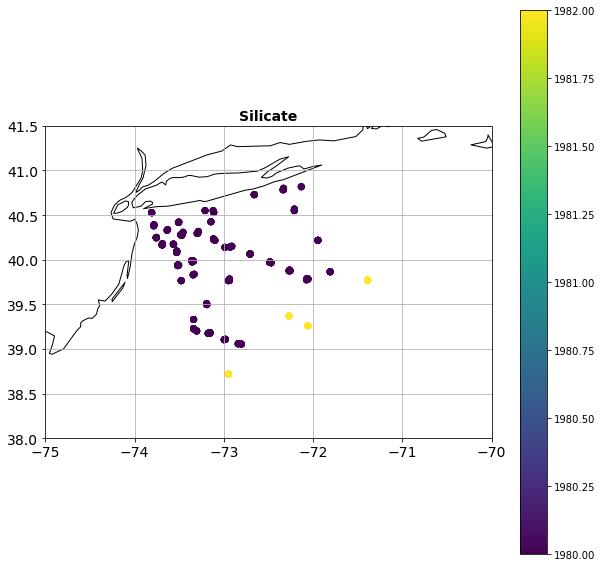

In [55]:
fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': ccrs.PlateCarree()})
extent = [285,290,38.5,41.5]
ax.set_extent(extent)
ax.gridlines()
ax.coastlines(resolution='50m')
C = ax.scatter(LON,LAT,c=YEAR)
fig.colorbar(C)
ax.set_xticks(np.arange(-75,-69,1), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(38,42,0.5), crs=ccrs.PlateCarree())
ax.tick_params(labelsize=14)
plt.title('Silicate', fontsize = 14, fontweight = 'bold')